In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Import our SCMS functions
from SCMS_fun import KDE, MS_KDE, SCMS_Log_KDE
from DirSCMS_fun import DirKDE, SCMS_Log_DirKDE
from Utility_fun import cart2sph, sph2cart

### Example Data

We obtain the earthquake from the Earthquake Catalog (https://earthquake.usgs.gov/earthquakes/search/) of the United States Geological Survey. For an illustrative purpose, only the earthquakes with magnitudes of 2.5+ in a one-month period (between 2020-08-19 00:00:00 UTCand 2020-09-18 23:59:59 UTC around the world).

In [2]:
EQ_dat = pd.read_csv('earthquakes20210819_0918.csv')
EQ_dat.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2021-09-18T00:56:07.651Z,-15.7101,-173.7083,76.13,5.1,mb,NaN,48.0,2.583,1.04,...,2021-09-18T01:20:11.040Z,"28 km NNE of Hihifo, Tonga",earthquake,8.3,6.4,0.027,460.0,reviewed,us,us
1,2021-09-18T00:03:13.875Z,56.6994,-157.0615,40.60,2.8,ml,NaN,NaN,NaN,0.51,...,2021-09-18T00:45:25.306Z,"92 km SSE of Ugashik, Alaska",earthquake,NaN,11.3,NaN,NaN,automatic,ak,ak
2,2021-09-17T23:45:30.700Z,37.9279,29.3609,10.00,4.2,mb,NaN,37.0,0.846,0.76,...,2021-09-18T00:21:49.040Z,"20 km NNE of Honaz, Turkey",earthquake,2.3,1.9,0.216,6.0,reviewed,us,us
3,2021-09-17T23:33:19.431Z,64.4307,-146.7083,6.70,3.1,ml,NaN,NaN,NaN,0.66,...,2021-09-17T23:56:28.039Z,"8 km NW of Harding-Birch Lakes, Alaska",earthquake,NaN,0.1,NaN,NaN,reviewed,ak,ak
4,2021-09-17T23:15:28.848Z,53.1843,-160.1547,29.36,3.1,ml,NaN,236.0,1.683,0.70,...,2021-09-17T23:36:50.040Z,"240 km S of Sand Point, Alaska",earthquake,8.2,11.3,0.091,16.0,reviewed,us,us


In [3]:
# Extract the location and magnitude information
X, Y, Z = sph2cart(*EQ_dat[['longitude', 'latitude']].values.T)
EQ_cart = np.concatenate([X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)], axis=1)
mag = EQ_dat['mag'].values
EQ_ang = EQ_dat[['longitude', 'latitude']].values

### Density Estimation and (Weighted) Usual/Euclidean SCMS Algorithm for Ridge-Finding

We estimate the earthquake density and pursue its density ridges based on the location records (latitudes and longitudes) and weighted by their magnitudes.

In [4]:
# Unweighted Version (wt=None; every data point contributes an equal weight in density and ridge estimations)
## Estimate the density values on a set of mesh points on the sphere (Earth)
nrows, ncols = (90, 180)
lon, lat = np.meshgrid(np.linspace(-180, 180, ncols), 
                       np.linspace(-90, 90, nrows))
query_points_ang = np.concatenate((lon.reshape(nrows*ncols, 1), 
                                   lat.reshape(nrows*ncols, 1)), axis=1)
# Bandwidth parameter for Euclidean KDE/SCMS
bw_Eu = None
d_Eu_unweight = KDE(query_points_ang, EQ_ang, h=bw_Eu, wt=None).reshape(nrows, ncols)

## Finding the Euclidean ridges on a set of uniformly distributed points on the sphere (Earth)
# Sample 5000 points uniformly on the sphere as the mesh points 
# Feel free to use mesh points as the set of initial points
np.random.seed(123)  ## Set an arbitrary seed for reproducibility
mesh_pts = np.random.multivariate_normal(mean=[0,0,0], cov=np.eye(3), size=5000)
mesh_pts = mesh_pts/LA.norm(mesh_pts, axis=1).reshape(-1,1)
lon_m, lat_m, R = cart2sph(*mesh_pts.T)
# Latitudes and longitudes of mesh points
mesh_pts_ang = np.concatenate((lon_m.reshape(-1, 1), 
                               lat_m.reshape(-1, 1)), axis=1)
# We use the logarithmic version of SCMS algorithm for faster and more stable convergence
SCMS_Eu_unweight = SCMS_Log_KDE(mesh_pts_ang, EQ_ang, d=1, h=bw_Eu, eps=1e-9, max_iter=5000, wt=None)

The current bandwidth is 20.957668810268267.

The current bandwidth is 20.957668810268267.

The SCMS algorithm converges in 762steps!


In [5]:
# Weighted Version (wt=mag)
## Estimate the density values on a set of mesh points on the sphere (Earth)
nrows, ncols = (90, 180)
lon, lat = np.meshgrid(np.linspace(-180, 180, ncols), 
                       np.linspace(-90, 90, nrows))
query_points_ang = np.concatenate((lon.reshape(nrows*ncols, 1), 
                                   lat.reshape(nrows*ncols, 1)), axis=1)
# Bandwidth parameter for Euclidean KDE/SCMS
bw_Eu = None
d_Eu_weight = KDE(query_points_ang, EQ_ang, h=bw_Eu, wt=mag).reshape(nrows, ncols)

## Finding the Euclidean ridges on a set of uniformly distributed points on the sphere (Earth)
# Sample 5000 points uniformly on the sphere as the mesh points 
# Feel free to use mesh points as the set of initial points
np.random.seed(123)  ## Set an arbitrary seed for reproducibility
mesh_pts = np.random.multivariate_normal(mean=[0,0,0], cov=np.eye(3), size=5000)
mesh_pts = mesh_pts/LA.norm(mesh_pts, axis=1).reshape(-1,1)
lon_m, lat_m, R = cart2sph(*mesh_pts.T)
# Latitudes and longitudes of mesh points
mesh_pts_ang = np.concatenate((lon_m.reshape(-1, 1), 
                               lat_m.reshape(-1, 1)), axis=1)
# We use the logarithmic version of SCMS algorithm for faster and more stable convergence
SCMS_Eu_weight = SCMS_Log_KDE(mesh_pts_ang, EQ_ang, d=1, h=bw_Eu, eps=1e-9, max_iter=5000, wt=mag)

The current bandwidth is 20.957668810268267.

The current bandwidth is 20.957668810268267.

The SCMS algorithm converges in 210steps!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


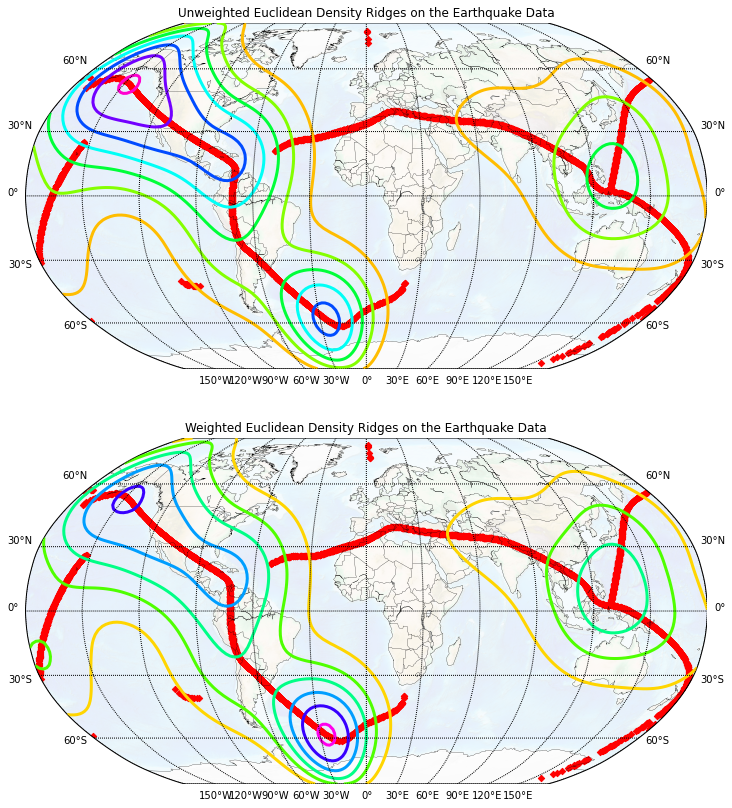

In [6]:
fig = plt.figure(figsize=(16, 14))
plt.subplot(211)
final_step1 = SCMS_Eu_unweight.shape[2]-1
lon1 = SCMS_Eu_unweight[:,0,final_step1]
lat1 = SCMS_Eu_unweight[:,1,final_step1]
m1 = Basemap(projection='robin', lon_0=0, resolution='c')
# Draw coastlines, country boundaries, fill continents.
m1.drawcoastlines(linewidth=0.25)
m1.drawcountries(linewidth=0.25)
m1.etopo(scale=0.5, alpha=0.1)
# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30), labels=[1,1,0,1])
m1.drawparallels(np.arange(-90, 90, 30), labels=[1,1,0,1])
x1, y1 = m1(lon1, lat1)
x, y = m1(lon, lat)
cs = m1.scatter(x1, y1, color='red', s=20, marker='D')
cs = m1.contour(x, y, d_Eu_unweight, linewidths=3, cmap='hsv')
plt.title('Unweighted Euclidean Density Ridges on the Earthquake Data')

plt.subplot(212)
final_step2 = SCMS_Eu_weight.shape[2]-1
lon2 = SCMS_Eu_weight[:,0,final_step2]
lat2 = SCMS_Eu_weight[:,1,final_step2]
m2 = Basemap(projection='robin', lon_0=0, resolution='c')
# Draw coastlines, country boundaries, fill continents.
m2.drawcoastlines(linewidth=0.25)
m2.drawcountries(linewidth=0.25)
m2.etopo(scale=0.5, alpha=0.1)
# Draw lat/lon grid lines every 30 degrees.
m2.drawmeridians(np.arange(-180, 180, 30), labels=[1,1,0,1])
m2.drawparallels(np.arange(-90, 90, 30), labels=[1,1,0,1])
x2, y2 = m2(lon2, lat2)
x, y = m2(lon, lat)
cs = m2.scatter(x2, y2, color='red', s=20, marker='D')
cs = m2.contour(x, y, d_Eu_weight, linewidths=3, cmap='hsv')
plt.title('Weighted Euclidean Density Ridges on the Earthquake Data')
plt.show()

### Directional Density Estimation and (Weighted) SCMS Algorithm for Ridge-Finding

One drawback of estimating the density and its ridge directly on latitudes and longitudes is that it ignores the spherical geometry on which the data lie. To resolve this issue, we introduce a new directional KDE and SCMS algorithm (https://arxiv.org/abs/2104.14977).

In [7]:
# Unweighted Version (wt=None; every data point contributes an equal weight in density and ridge estimations)
## Estimate the density values on a set of mesh points on the sphere (Earth)
nrows, ncols = (90, 180)
lon, lat = np.meshgrid(np.linspace(-180, 180, ncols), 
                       np.linspace(-90, 90, nrows))
xg, yg, zg = sph2cart(lon, lat)
query_points = np.concatenate((xg.reshape(nrows*ncols, 1), 
                               yg.reshape(nrows*ncols, 1),
                               zg.reshape(nrows*ncols, 1)), axis=1)
# Bandwidth parameter for directional KDE/SCMS
# We use the default rule-of-thumb value. However, the bandwidth need to be fine-tuned.
bw_Dir = None
d_Dir_unweight = DirKDE(query_points, EQ_cart, h=bw_Dir, wt=None).reshape(nrows, ncols)

## Finding the Euclidean ridges on a set of uniformly distributed points on the sphere (Earth)
# Sample 5000 points uniformly on the sphere as the mesh points 
# Feel free to use mesh points as the set of initial points
np.random.seed(123)  ## Set an arbitrary seed for reproducibility
mesh_pts = np.random.multivariate_normal(mean=[0,0,0], cov=np.eye(3), size=5000)
mesh_pts = mesh_pts/LA.norm(mesh_pts, axis=1).reshape(-1,1)
# We use the logarithmic version of directional SCMS algorithm for faster and more stable convergence
SCMS_Dir_unweight = SCMS_Log_DirKDE(mesh_pts, EQ_cart, d=1, h=bw_Dir, eps=1e-9, max_iter=5000, wt=None)

The current bandwidth is 0.27660491486533456.

The current bandwidth is 0.27660491486533456.

The directional SCMS algorithm converges in 3192steps!


In [8]:
# Weighted Version (wt=mag)
## Estimate the density values on a set of mesh points on the sphere (Earth)
nrows, ncols = (90, 180)
lon, lat = np.meshgrid(np.linspace(-180, 180, ncols), 
                       np.linspace(-90, 90, nrows))
xg, yg, zg = sph2cart(lon, lat)
query_points = np.concatenate((xg.reshape(nrows*ncols, 1), 
                               yg.reshape(nrows*ncols, 1),
                               zg.reshape(nrows*ncols, 1)), axis=1)
# Bandwidth parameter for Euclidean KDE/SCMS
bw_Dir = None
d_Dir_weight = DirKDE(query_points, EQ_cart, h=bw_Dir, wt=mag).reshape(nrows, ncols)

## Finding the Euclidean ridges on a set of uniformly distributed points on the sphere (Earth)
# Sample 5000 points uniformly on the sphere as the mesh points 
# Feel free to use mesh points as the set of initial points
np.random.seed(123)  ## Set an arbitrary seed for reproducibility
mesh_pts = np.random.multivariate_normal(mean=[0,0,0], cov=np.eye(3), size=5000)
mesh_pts = mesh_pts/LA.norm(mesh_pts, axis=1).reshape(-1,1)
# We use the logarithmic version of directional SCMS algorithm for faster and more stable convergence
SCMS_Dir_weight = SCMS_Log_DirKDE(mesh_pts, EQ_cart, d=1, h=bw_Dir, eps=1e-9, max_iter=5000, wt=mag)

The current bandwidth is 0.27660491486533456.

The current bandwidth is 0.27660491486533456.

The directional SCMS algorithm converges in 1097steps!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


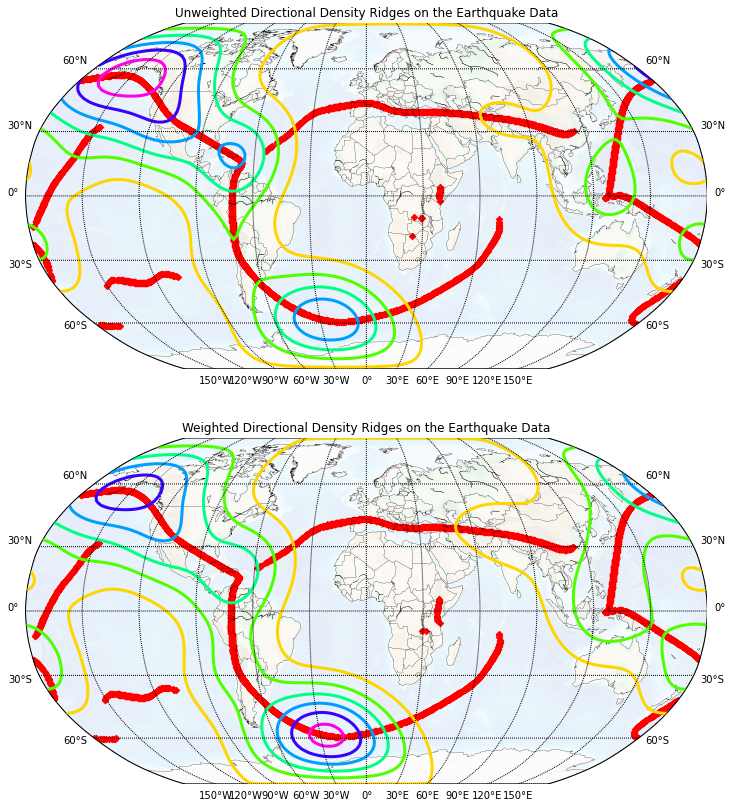

In [9]:
fig = plt.figure(figsize=(16, 14))
plt.subplot(211)
final_step1 = SCMS_Dir_unweight.shape[2]-1
lon1, lat1, R = cart2sph(*SCMS_Dir_unweight[:,:,final_step1].T)
m1 = Basemap(projection='robin', lon_0=0, resolution='c')
# Draw coastlines, country boundaries, fill continents.
m1.drawcoastlines(linewidth=0.25)
m1.drawcountries(linewidth=0.25)
m1.etopo(scale=0.5, alpha=0.1)
# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30), labels=[1,1,0,1])
m1.drawparallels(np.arange(-90, 90, 30), labels=[1,1,0,1])
x1, y1 = m1(lon1, lat1)
x, y = m1(lon, lat)
cs = m1.scatter(x1, y1, color='red', s=20, marker='D')
cs = m1.contour(x, y, d_Dir_unweight, linewidths=3, cmap='hsv')
plt.title('Unweighted Directional Density Ridges on the Earthquake Data')

plt.subplot(212)
final_step2 = SCMS_Dir_weight.shape[2]-1
lon2, lat2, R = cart2sph(*SCMS_Dir_weight[:,:,final_step2].T)
m2 = Basemap(projection='robin', lon_0=0, resolution='c')
# Draw coastlines, country boundaries, fill continents.
m2.drawcoastlines(linewidth=0.25)
m2.drawcountries(linewidth=0.25)
m2.etopo(scale=0.5, alpha=0.1)
# Draw lat/lon grid lines every 30 degrees.
m2.drawmeridians(np.arange(-180, 180, 30), labels=[1,1,0,1])
m2.drawparallels(np.arange(-90, 90, 30), labels=[1,1,0,1])
x2, y2 = m2(lon2, lat2)
x, y = m2(lon, lat)
cs = m2.scatter(x2, y2, color='red', s=20, marker='D')
cs = m2.contour(x, y, d_Dir_weight, linewidths=3, cmap='hsv')
plt.title('Weighted Directional Density Ridges on the Earthquake Data')
plt.show()

### Parallel Implementation of (Weighted) Euclidean/Directional SCMS Algorithms

When dealing with large-scale data, we provide parallel implementations of (weighted) Euclidean and directional SCMS algorithms under the "ray" environment (https://ray.io/).

In [10]:
from MS_SCMS_Ray import SCMS_Log_KDE_Fs, SCMS_Log_DirKDE_Fs
import ray

In [11]:
## Sample 5000 points uniformly on the sphere as the mesh points
np.random.seed(123)  ## Set an arbitrary seed for reproducibility
mesh_pts = np.random.multivariate_normal(mean=[0,0,0], cov=np.eye(3), 
                                         size=5000)
mesh_pts = mesh_pts/LA.norm(mesh_pts, axis=1).reshape(-1,1)
lon_m, lat_m, R = cart2sph(*mesh_pts.T)
mesh_pts_ang = np.concatenate((lon_m.reshape(-1, 1), 
                                lat_m.reshape(-1, 1)), axis=1)

In [12]:
ray.init()
chunksize = 10
num_p = mesh_pts.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(SCMS_Log_DirKDE_Fs.remote(mesh_pts[i:(i+chunksize)], EQ_cart, d=1, h=bw_Dir, 
                                                eps=1e-9, max_iter=5000, wt=mag))
DirSCMS_pts = ray.get(result_ids)
DirSCMS_pts = np.concatenate(DirSCMS_pts, axis=0)
ray.shutdown()

ray.init()
chunksize = 10
num_p = mesh_pts_ang.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(SCMS_Log_KDE_Fs.remote(mesh_pts_ang[i:(i+chunksize)], EQ_ang, d=1, h=bw_Eu, 
                                             eps=1e-9, max_iter=5000, wt=mag))
EuSCMS_pts = ray.get(result_ids)
EuSCMS_pts = np.concatenate(EuSCMS_pts, axis=0)
ray.shutdown()

2021-09-17 20:01:50,435	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=7186) The current bandwidth is 0.27660491486533456.
(pid=7186) 
(pid=7187) The current bandwidth is 0.27660491486533456.
(pid=7187) 
(pid=7189) The current bandwidth is 0.27660491486533456.
(pid=7189) 
(pid=7188) The current bandwidth is 0.27660491486533456.
(pid=7188) 
(pid=7183) The current bandwidth is 0.27660491486533456.
(pid=7183) 
(pid=7185) The current bandwidth is 0.27660491486533456.
(pid=7185) 
(pid=7184) The current bandwidth is 0.27660491486533456.
(pid=7184) 
(pid=7190) The current bandwidth is 0.27660491486533456.
(pid=7190) 
(pid=7189) The current bandwidth is 0.27660491486533456.
(pid=7189) 
(pid=7186) The current bandwidth is 0.27660491486533456.
(pid=7186) 
(pid=7187) The current bandwidth is 0.27660491486533456.
(pid=7187) 
(pid=7188) The current bandwidth is 0.27660491486533456.
(pid=7188) 
(pid=7190) The current bandwidth is 0.27660491486533456.
(pid=7190) 
(pid=7183) The current bandwidth is 0.27660491486533456.
(pid=7183) 
(pid=7185) The current bandwidth i

(pid=7183) The current bandwidth is 0.27660491486533456.
(pid=7183) 
(pid=7188) The current bandwidth is 0.27660491486533456.
(pid=7188) 
(pid=7187) The current bandwidth is 0.27660491486533456.
(pid=7187) 
(pid=7185) The current bandwidth is 0.27660491486533456.
(pid=7185) 
(pid=7186) The current bandwidth is 0.27660491486533456.
(pid=7186) 
(pid=7189) The current bandwidth is 0.27660491486533456.
(pid=7189) 
(pid=7184) The current bandwidth is 0.27660491486533456.
(pid=7184) 
(pid=7190) The current bandwidth is 0.27660491486533456.
(pid=7190) 
(pid=7188) The current bandwidth is 0.27660491486533456.
(pid=7188) 
(pid=7187) The current bandwidth is 0.27660491486533456.
(pid=7187) 
(pid=7183) The current bandwidth is 0.27660491486533456.
(pid=7183) 
(pid=7189) The current bandwidth is 0.27660491486533456.
(pid=7189) 
(pid=7185) The current bandwidth is 0.27660491486533456.
(pid=7185) 
(pid=7190) The current bandwidth is 0.27660491486533456.
(pid=7190) 
(pid=7186) The current bandwidth i

(pid=7183) The current bandwidth is 0.27660491486533456.
(pid=7183) 
(pid=7190) The current bandwidth is 0.27660491486533456.
(pid=7190) 
(pid=7188) The current bandwidth is 0.27660491486533456.
(pid=7188) 
(pid=7185) The current bandwidth is 0.27660491486533456.
(pid=7185) 
(pid=7189) The current bandwidth is 0.27660491486533456.
(pid=7189) 
(pid=7184) The current bandwidth is 0.27660491486533456.
(pid=7184) 
(pid=7186) The current bandwidth is 0.27660491486533456.
(pid=7186) 
(pid=7187) The current bandwidth is 0.27660491486533456.
(pid=7187) 
(pid=7183) The current bandwidth is 0.27660491486533456.
(pid=7183) 
(pid=7190) The current bandwidth is 0.27660491486533456.
(pid=7190) 
(pid=7189) The current bandwidth is 0.27660491486533456.
(pid=7189) 
(pid=7188) The current bandwidth is 0.27660491486533456.
(pid=7188) 
(pid=7185) The current bandwidth is 0.27660491486533456.
(pid=7185) 
(pid=7184) The current bandwidth is 0.27660491486533456.
(pid=7184) 
(pid=7187) The current bandwidth i

(pid=7183) The current bandwidth is 0.27660491486533456.
(pid=7183) 
(pid=7189) The current bandwidth is 0.27660491486533456.
(pid=7189) 
(pid=7186) The current bandwidth is 0.27660491486533456.
(pid=7186) 
(pid=7188) The current bandwidth is 0.27660491486533456.
(pid=7188) 
(pid=7184) The current bandwidth is 0.27660491486533456.
(pid=7184) 
(pid=7185) The current bandwidth is 0.27660491486533456.
(pid=7185) 
(pid=7190) The current bandwidth is 0.27660491486533456.
(pid=7190) 
(pid=7187) The current bandwidth is 0.27660491486533456.
(pid=7187) 
(pid=7183) The current bandwidth is 0.27660491486533456.
(pid=7183) 
(pid=7189) The current bandwidth is 0.27660491486533456.
(pid=7189) 
(pid=7188) The current bandwidth is 0.27660491486533456.
(pid=7188) 
(pid=7184) The current bandwidth is 0.27660491486533456.
(pid=7184) 
(pid=7190) The current bandwidth is 0.27660491486533456.
(pid=7190) 
(pid=7186) The current bandwidth is 0.27660491486533456.
(pid=7186) 
(pid=7183) The current bandwidth i

(pid=7187) The current bandwidth is 0.27660491486533456.
(pid=7187) 
(pid=7188) The current bandwidth is 0.27660491486533456.
(pid=7188) 
(pid=7186) The current bandwidth is 0.27660491486533456.
(pid=7186) 
(pid=7189) The current bandwidth is 0.27660491486533456.
(pid=7189) 
(pid=7185) The current bandwidth is 0.27660491486533456.
(pid=7185) 
(pid=7184) The current bandwidth is 0.27660491486533456.
(pid=7184) 
(pid=7187) The current bandwidth is 0.27660491486533456.
(pid=7187) 
(pid=7188) The current bandwidth is 0.27660491486533456.
(pid=7188) 
(pid=7190) The current bandwidth is 0.27660491486533456.
(pid=7190) 
(pid=7183) The current bandwidth is 0.27660491486533456.
(pid=7183) 
(pid=7186) The current bandwidth is 0.27660491486533456.
(pid=7186) 
(pid=7189) The current bandwidth is 0.27660491486533456.
(pid=7189) 
(pid=7185) The current bandwidth is 0.27660491486533456.
(pid=7185) 
(pid=7184) The current bandwidth is 0.27660491486533456.
(pid=7184) 
(pid=7188) The current bandwidth i

(pid=7185) The current bandwidth is 0.27660491486533456.
(pid=7185) 
(pid=7184) The current bandwidth is 0.27660491486533456.
(pid=7184) 
(pid=7187) The current bandwidth is 0.27660491486533456.
(pid=7187) 
(pid=7189) The current bandwidth is 0.27660491486533456.
(pid=7189) 
(pid=7183) The current bandwidth is 0.27660491486533456.
(pid=7183) 
(pid=7185) The current bandwidth is 0.27660491486533456.
(pid=7185) 
(pid=7190) The current bandwidth is 0.27660491486533456.
(pid=7190) 
(pid=7188) The current bandwidth is 0.27660491486533456.
(pid=7188) 
(pid=7186) The current bandwidth is 0.27660491486533456.
(pid=7186) 
(pid=7184) The current bandwidth is 0.27660491486533456.
(pid=7184) 
(pid=7187) The current bandwidth is 0.27660491486533456.
(pid=7187) 
(pid=7189) The current bandwidth is 0.27660491486533456.
(pid=7189) 
(pid=7183) The current bandwidth is 0.27660491486533456.
(pid=7183) 
(pid=7190) The current bandwidth is 0.27660491486533456.
(pid=7190) 
(pid=7188) The current bandwidth i

2021-09-17 20:02:26,246	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=7500) The current bandwidth is 20.957668810268267.
(pid=7500) 
(pid=7503) The current bandwidth is 20.957668810268267.
(pid=7503) 
(pid=7499) The current bandwidth is 20.957668810268267.
(pid=7499) 
(pid=7502) The current bandwidth is 20.957668810268267.
(pid=7502) 
(pid=7505) The current bandwidth is 20.957668810268267.
(pid=7505) 
(pid=7498) The current bandwidth is 20.957668810268267.
(pid=7498) 
(pid=7504) The current bandwidth is 20.957668810268267.
(pid=7504) 
(pid=7501) The current bandwidth is 20.957668810268267.
(pid=7501) 
(pid=7503) The current bandwidth is 20.957668810268267.
(pid=7503) 
(pid=7502) The current bandwidth is 20.957668810268267.
(pid=7502) 
(pid=7501) The current bandwidth is 20.957668810268267.
(pid=7501) 
(pid=7500) The current bandwidth is 20.957668810268267.
(pid=7500) 
(pid=7505) The current bandwidth is 20.957668810268267.
(pid=7505) 
(pid=7503) The current bandwidth is 20.957668810268267.
(pid=7503) 
(pid=7499) The current bandwidth is 20.957668810

(pid=7505) The current bandwidth is 20.957668810268267.
(pid=7505) 
(pid=7498) The current bandwidth is 20.957668810268267.
(pid=7498) 
(pid=7500) The current bandwidth is 20.957668810268267.
(pid=7500) 
(pid=7504) The current bandwidth is 20.957668810268267.
(pid=7504) 
(pid=7499) The current bandwidth is 20.957668810268267.
(pid=7499) 
(pid=7502) The current bandwidth is 20.957668810268267.
(pid=7502) 
(pid=7498) The current bandwidth is 20.957668810268267.
(pid=7498) 
(pid=7503) The current bandwidth is 20.957668810268267.
(pid=7503) 
(pid=7500) The current bandwidth is 20.957668810268267.
(pid=7500) 
(pid=7502) The current bandwidth is 20.957668810268267.
(pid=7502) 
(pid=7505) The current bandwidth is 20.957668810268267.
(pid=7505) 
(pid=7501) The current bandwidth is 20.957668810268267.
(pid=7501) 
(pid=7504) The current bandwidth is 20.957668810268267.
(pid=7504) 
(pid=7503) The current bandwidth is 20.957668810268267.
(pid=7503) 
(pid=7499) The current bandwidth is 20.957668810

(pid=7500) The current bandwidth is 20.957668810268267.
(pid=7500) 
(pid=7503) The current bandwidth is 20.957668810268267.
(pid=7503) 
(pid=7505) The current bandwidth is 20.957668810268267.
(pid=7505) 
(pid=7504) The current bandwidth is 20.957668810268267.
(pid=7504) 
(pid=7499) The current bandwidth is 20.957668810268267.
(pid=7499) 
(pid=7498) The current bandwidth is 20.957668810268267.
(pid=7498) 
(pid=7503) The current bandwidth is 20.957668810268267.
(pid=7503) 
(pid=7505) The current bandwidth is 20.957668810268267.
(pid=7505) 
(pid=7501) The current bandwidth is 20.957668810268267.
(pid=7501) 
(pid=7500) The current bandwidth is 20.957668810268267.
(pid=7500) 
(pid=7502) The current bandwidth is 20.957668810268267.
(pid=7502) 
(pid=7504) The current bandwidth is 20.957668810268267.
(pid=7504) 
(pid=7499) The current bandwidth is 20.957668810268267.
(pid=7499) 
(pid=7498) The current bandwidth is 20.957668810268267.
(pid=7498) 
(pid=7504) The current bandwidth is 20.957668810

(pid=7500) The current bandwidth is 20.957668810268267.
(pid=7500) 
(pid=7498) The current bandwidth is 20.957668810268267.
(pid=7498) 
(pid=7505) The current bandwidth is 20.957668810268267.
(pid=7505) 
(pid=7502) The current bandwidth is 20.957668810268267.
(pid=7502) 
(pid=7504) The current bandwidth is 20.957668810268267.
(pid=7504) 
(pid=7501) The current bandwidth is 20.957668810268267.
(pid=7501) 
(pid=7503) The current bandwidth is 20.957668810268267.
(pid=7503) 
(pid=7500) The current bandwidth is 20.957668810268267.
(pid=7500) 
(pid=7499) The current bandwidth is 20.957668810268267.
(pid=7499) 
(pid=7505) The current bandwidth is 20.957668810268267.
(pid=7505) 
(pid=7498) The current bandwidth is 20.957668810268267.
(pid=7498) 
(pid=7504) The current bandwidth is 20.957668810268267.
(pid=7504) 
(pid=7503) The current bandwidth is 20.957668810268267.
(pid=7503) 
(pid=7502) The current bandwidth is 20.957668810268267.
(pid=7502) 
(pid=7501) The current bandwidth is 20.957668810

(pid=7500) The current bandwidth is 20.957668810268267.
(pid=7500) 
(pid=7503) The current bandwidth is 20.957668810268267.
(pid=7503) 
(pid=7502) The current bandwidth is 20.957668810268267.
(pid=7502) 
(pid=7504) The current bandwidth is 20.957668810268267.
(pid=7504) 
(pid=7499) The current bandwidth is 20.957668810268267.
(pid=7499) 
(pid=7505) The current bandwidth is 20.957668810268267.
(pid=7505) 
(pid=7498) The current bandwidth is 20.957668810268267.
(pid=7498) 
(pid=7503) The current bandwidth is 20.957668810268267.
(pid=7503) 
(pid=7502) The current bandwidth is 20.957668810268267.
(pid=7502) 
(pid=7504) The current bandwidth is 20.957668810268267.
(pid=7504) 
(pid=7501) The current bandwidth is 20.957668810268267.
(pid=7501) 
(pid=7499) The current bandwidth is 20.957668810268267.
(pid=7499) 
(pid=7500) The current bandwidth is 20.957668810268267.
(pid=7500) 
(pid=7505) The current bandwidth is 20.957668810268267.
(pid=7505) 
(pid=7498) The current bandwidth is 20.957668810

(pid=7498) The current bandwidth is 20.957668810268267.
(pid=7498) 
(pid=7504) The current bandwidth is 20.957668810268267.
(pid=7504) 
(pid=7503) The current bandwidth is 20.957668810268267.
(pid=7503) 
(pid=7502) The current bandwidth is 20.957668810268267.
(pid=7502) 
(pid=7500) The current bandwidth is 20.957668810268267.
(pid=7500) 
(pid=7499) The current bandwidth is 20.957668810268267.
(pid=7499) 
(pid=7505) The current bandwidth is 20.957668810268267.
(pid=7505) 
(pid=7498) The current bandwidth is 20.957668810268267.
(pid=7498) 
(pid=7501) The current bandwidth is 20.957668810268267.
(pid=7501) 
(pid=7500) The current bandwidth is 20.957668810268267.
(pid=7500) 
(pid=7503) The current bandwidth is 20.957668810268267.
(pid=7503) 
(pid=7502) The current bandwidth is 20.957668810268267.
(pid=7502) 
(pid=7504) The current bandwidth is 20.957668810268267.
(pid=7504) 
(pid=7499) The current bandwidth is 20.957668810268267.
(pid=7499) 
(pid=7505) The current bandwidth is 20.957668810

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


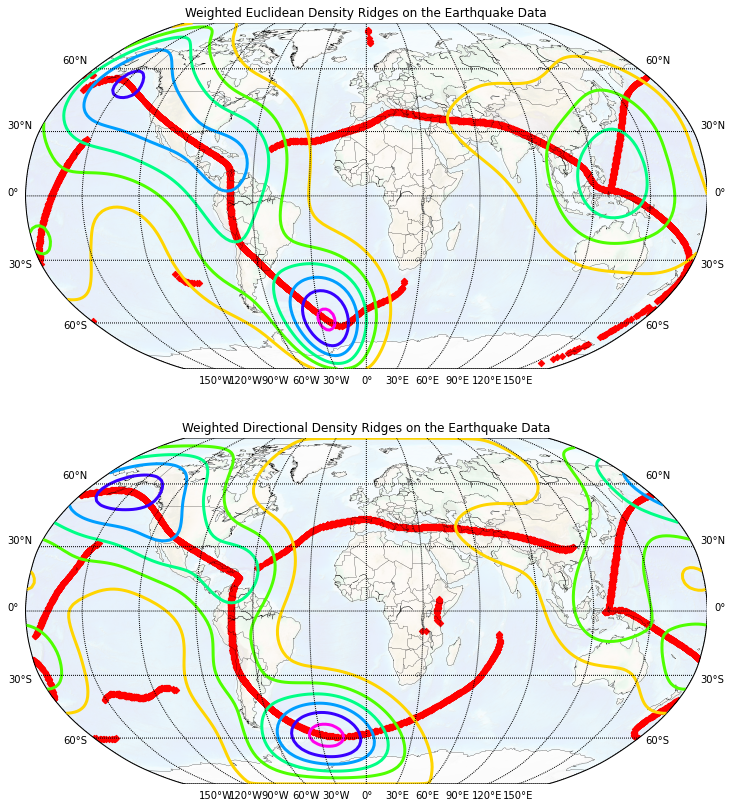

In [13]:
fig = plt.figure(figsize=(16, 14))
plt.subplot(211)
lon1 = EuSCMS_pts[:,0]
lat1 = EuSCMS_pts[:,1]
m1 = Basemap(projection='robin', lon_0=0, resolution='c')
# Draw coastlines, country boundaries, fill continents.
m1.drawcoastlines(linewidth=0.25)
m1.drawcountries(linewidth=0.25)
m1.etopo(scale=0.5, alpha=0.1)
# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30), labels=[1,1,0,1])
m1.drawparallels(np.arange(-90, 90, 30), labels=[1,1,0,1])
x1, y1 = m1(lon1, lat1)
x, y = m1(lon, lat)
cs = m1.scatter(x1, y1, color='red', s=20, marker='D')
cs = m1.contour(x, y, d_Eu_weight, linewidths=3, cmap='hsv')
plt.title('Weighted Euclidean Density Ridges on the Earthquake Data')

plt.subplot(212)
lon2, lat2, R = cart2sph(*DirSCMS_pts.T)
m2 = Basemap(projection='robin', lon_0=0, resolution='c')
# Draw coastlines, country boundaries, fill continents.
m2.drawcoastlines(linewidth=0.25)
m2.drawcountries(linewidth=0.25)
m2.etopo(scale=0.5, alpha=0.1)
# Draw lat/lon grid lines every 30 degrees.
m2.drawmeridians(np.arange(-180, 180, 30), labels=[1,1,0,1])
m2.drawparallels(np.arange(-90, 90, 30), labels=[1,1,0,1])
x2, y2 = m2(lon2, lat2)
x, y = m2(lon, lat)
cs = m2.scatter(x2, y2, color='red', s=20, marker='D')
cs = m2.contour(x, y, d_Dir_weight, linewidths=3, cmap='hsv')
plt.title('Weighted Directional Density Ridges on the Earthquake Data')
plt.show()